# Import Dependencies, Download and Unpack Images

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model


In [ ]:
#download images folder
!wget http://images.cocodataset.org/zips/train2017.zip

In [ ]:
#unzip images folder
!unzip train2017.zip

# Set General Parameters for Text and Image Processing

In [ ]:
# Desired image dimensions
IMAGE_SIZE = (224, 224)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

# Match Captions with Images, Setup Text Processing

In [ ]:
import json
#Upload James' 'caption_to_img.json' and run this code block
#swapped will contain a dictionary such that each key is a path to an img in train2017, and each value is a list of the five captions corresponding to that img
data=None
with open('caption_to_img.json') as json_file:
    data = json.load(json_file)
swapped = {}
for k, v in data.items():
    v = v#'train2017/' + v
    if v not in swapped:
        swapped[v] = list()
    swapped[v].append(k)

for k in list(swapped.keys()):
  if len(swapped[k]) != 5:
    swapped.pop(k)

In [ ]:
#text processing functions
def flatten(l):
    return ["<start> " + item.strip() + " <end>" for sublist in l for item in sublist]

text_data = flatten(swapped.values())

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Create Input Datasets and Model Parameters for Model Training

In [ ]:
#set seed and create dataset, code adapted from tutorials
seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_data, valid_data = train_val_split(swapped)
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [ ]:
#here we define the models
#note though that for RNN and LSTM we do not use the CNN during training,
#but instead pre-extracted the image features to file.npy to save time during training
#we still use the CNN to get image features when predicting captions
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0()
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.layers[-2].output
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

#define the RNN model, very similar to LSTM model, just one layer changes
inputs1 = tf.keras.layers.Input(shape=(1280,))
fe1 = tf.keras.layers.Dropout(0.4)(inputs1)
fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = tf.keras.layers.Input(shape=(SEQ_LENGTH,))
se1 = tf.keras.layers.Embedding(VOCAB_SIZE, 256, mask_zero=True)(inputs2)
se2 = tf.keras.layers.Dropout(0.4)(se1)
se3 = tf.keras.layers.SimpleRNN(256)(se2)

# decoder model
decoder1 = tf.keras.layers.add([fe2, se3])
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
outputs = tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')(decoder2)

rnn_model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
train_keys = train_data.keys()
features = np.load('file.npy', allow_pickle='TRUE').item()

# Define Functions for Data Input and Train/Save the Model

In [ ]:
#define function to feed sequence to model during training
def data_generator(data_keys, mapping, features, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = vectorization(caption).numpy()
#                 print(seq)
                # split the sequence into X, y pairs
                l = min(25,len(caption.split()))
                for i in range(1, l):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
#                     print(in_seq)
#                     print(out_seq)
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=SEQ_LENGTH)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]
#                     print(in_seq)
#                     print(out_seq)
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#                 print(X2.shape)
#                 print(y.shape)
#                 print(X1)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
train_keys = train_data.keys()
epochs = 10
batch_size = 32
steps = len(train_keys) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_keys, train_data, features, batch_size)
    # fit for one epoch
    rnn_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    rnn_model.save('best_model')

    !zip -r /content/drive/MyDrive/best_model.zip /content/best_model
    new_model = tf.keras.models.load_model('best_model')


In [ ]:
#to continue training in event of notebook disconnect
#!unzip /content/drive/MyDrive/best_model.zip -d /content/my_best_model

In [ ]:
#to continue training in event of notebook disconnect

rnn_model = tf.keras.models.load_model('my_best_model/content/best_model')
#rnn_model.summary()

# for i in range(2):
#     # create data generator
#     generator = data_generator(train_keys, train_data, features, batch_size)
#     # fit for one epoch
#     rnn_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     rnn_model.save('best_model')

#     !zip -r /content/drive/MyDrive/best_model.zip /content/best_model
#     new_model = tf.keras.models.load_model('best_model')

#Functions for Caption Prediction

In [ ]:
index_to_word = vectorization.get_vocabulary()
cnn_model = get_cnn_model()
def predict_caption(model, image):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over the max length of sequence
    for i in range(SEQ_LENGTH):
        # encode input sequence
        sequence = vectorization(in_text)
#         print(sequence)
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=SEQ_LENGTH)
#         print(sequence)
        # predict next word
        yhat = rnn_model.predict([image, sequence], verbose=0)
#         print(yhat)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = index_to_word[yhat]
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
      
    return in_text

21848064/21834768 [==============================] - 0s 0us/step


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name, output = True):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    #img_path = os.path.join(BASE_DIR, image_name)
    #print(image_name)
    img_path = 'train2017/' + image_name
    imageShow = Image.open(img_path)
    captions = swapped[image_name]
    if output:
      print('---------------------Actual---------------------')
      for caption in captions:
          print(caption)
      # predict the caption
      image = load_img(img_path, target_size=(224, 224))
      # convert image pixels to numpy array
      image = img_to_array(image)
      # reshape data for model
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      # preprocess image for vgg
      image = preprocess_input(image)
      # extract features
      feature = cnn_model.predict(image, verbose=0)
      y_pred = predict_caption(rnn_model, feature)
      print('--------------------Predicted--------------------')
      print(y_pred)
      plt.imshow(imageShow)
    else:
      # predict the caption
      image = load_img(img_path, target_size=(224, 224))
      # convert image pixels to numpy array
      image = img_to_array(image)
      # reshape data for model
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      # preprocess image for vgg
      image = preprocess_input(image)
      # extract features
      feature = cnn_model.predict(image, verbose=0)
      y_pred = predict_caption(rnn_model, feature)
    return y_pred

# Functions and Loop for Valuation/Metrics

In [ ]:
#dependencies for testing
!pip install rouge-score
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
import nltk
from nltk.translate import bleu_score
from nltk.translate import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
#testing 
BLEU = 0
BLEU2 = 0
METEOR = 0
ROUGE = np.zeros(3)

x = 0
#saved metrics for notebook timeout, validation takes ~6-8 hours on colab
saved_metrics = np.loadtxt('/content/drive/MyDrive/20000th_val_data_chunk')
loaded = False #set this to true and edit the file path if loading partial results
if loaded:
  x = int(saved_metrics[0])
  BLEU = float(saved_metrics[1])
  BLEU2 = float(saved_metrics[2])
  METEOR = float(saved_metrics[3])
  ROUGE = np.array([float(saved_metrics[4]), float(saved_metrics[45]), float(saved_metrics[5])])

val_img_list = list(valid_data.keys())
for i in range(x,len(val_img_list)):
  if i%1000 == 0:
    print(i/len(val_img_list))
    save_array = np.asarray([i, BLEU, BLEU2, METEOR, ROUGE[0], ROUGE[1], ROUGE[2]])
    output = '/content/drive/MyDrive/'+str(i) + 'th_val_data_chunk'
    np.savetxt(output, save_array, delimiter=",")
  #predict the caption based on the image
  img = val_img_list[i]
  ###PREDICTION
  hypothesis = generate_caption(img, False) #generates the string
  hypothesis = custom_standardization(hypothesis)
  hypothesis = str(hypothesis.numpy())
  hypothesis = word_tokenize(hypothesis)[5:-1]
  #get actual captions
  captions = valid_data[img]
  references = []
  for caption in captions:
    caption = str(custom_standardization(caption).numpy())
    caption = word_tokenize(caption[2:-1])
    references.append(caption)
  #bleu score (can be done against all 5 reference captions at once using corpus_bleu)
  BLEU += bleu_score.sentence_bleu(references, hypothesis, weights = [1/3,1/3,1/3,0])
  BLEU2 += bleu_score.sentence_bleu(references, hypothesis, weights = [1/2,1/2,0,0])
  #meteor score works much the same way
  METEOR += meteor_score.meteor_score(references, hypothesis)

  #rouge looks like it needs to be done a caption at a time, and it looks like it needs joined strings
  j = 0
  temp_rouge = np.zeros(3)
  r_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
  for ref in references:
    ref_cap = ' '.join(ref)
    hyp = ' '.join(hypothesis)
    r_score = r_scorer.score(ref_cap, hyp)
    temp_rouge += np.array([r_score['rouge1'].precision, r_score['rouge1'].recall, r_score['rouge1'].fmeasure])
    j += 1

  ROUGE += temp_rouge/j
  
#divide by num_val images for average scores
BLEU = BLEU/len(val_img_list)
BLEU2 = BLEU2/len(val_img_list)
METEOR = METEOR/len(val_img_list)
ROUGE = ROUGE/len(val_img_list)

print(BLEU)
print(BLEU2)
print(METEOR)
print(ROUGE)


#Example Captions

---------------------Actual---------------------
A man with a tennis racket plays a game.
A crowd gathered to watch a tennis match.
Man walking onto the court during a professional tennis match
An old picture of a person playing in a tennis game.
A tennis player walking on the court during a match
--------------------Predicted--------------------
<start> outfielder in a baseball game of a match of fans watching him to serve the ball in the air on a tennis court with a


'<start> outfielder in a baseball game of a match of fans watching him to serve the ball in the air on a tennis court with a'

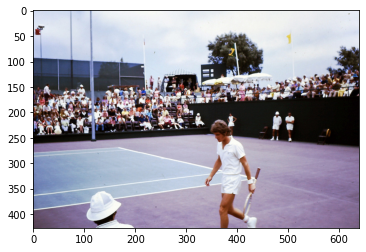

In [ ]:
# val_img_list = list(valid_data.keys())
# rand = np.random.randint(0,len(val_img_list)-1, size = (1))
# for i in rand:
#   print(val_img_list[i])
#   generate_caption(val_img_list[i])

generate_caption('000000248333.jpg')

---------------------Actual---------------------
A polar bear sitting on some rocks. 
A large white polar bear sitting on top of a rocky ground.
A polar bear sitting on a stone in his exhibit.
A polar bear sits in the sun and dries off.
A polar bear sitting on some ice by a fence.
--------------------Predicted--------------------
<start> polar bear standing by a pool of water with its paws on its paws on a persons legs of its paws on a shoe on


'<start> polar bear standing by a pool of water with its paws on its paws on a persons legs of its paws on a shoe on'

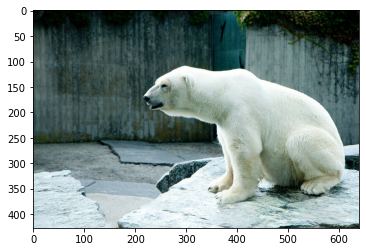

In [ ]:
generate_caption('000000403278.jpg')

---------------------Actual---------------------
A group of airplanes that are sitting on a runway.
some white jets are lined up on a runway
Several airliners taxiing one by one on the tarmac
A line of airplanes waits to take off at an airport.
Modern jet airplanes lined up on the runway ready for take off
--------------------Predicted--------------------
<start> airways express plane on a runway at an airport terminal at an airport runway at an airport terminal at an airport terminal at an airport


'<start> airways express plane on a runway at an airport terminal at an airport runway at an airport terminal at an airport terminal at an airport'

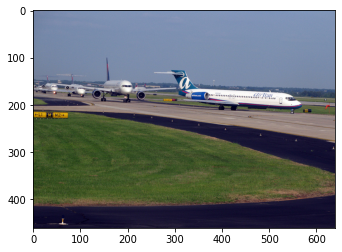

In [ ]:
generate_caption('000000414178.jpg')

---------------------Actual---------------------
a wireless  computer mouse on a wooden table 
A cat tail next to a mouse 
A MOUSE KEPT JUST BESIDES A CAT'S TAIL.
A cat with it's paw next to a computer mouse on a wooden table.
A computer mouse with a cat's paw next to it.
--------------------Predicted--------------------
<start> deserts on a plate on a table with a knife on it and a cup of coffee on it and a cup of coffee on


'<start> deserts on a plate on a table with a knife on it and a cup of coffee on it and a cup of coffee on'

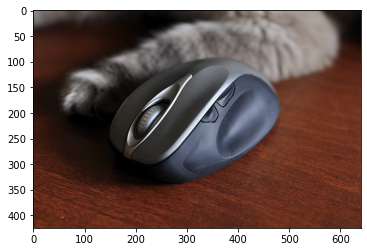

In [ ]:
generate_caption('000000061025.jpg')

---------------------Actual---------------------
A white wedding cake with a decorative top.
A three layer white cake with a symbol on top.
A three tiered wedding cake in white is shown with a large S on top.
An elegant wedding cake topped with a cursive S.
This beautiful wedding cake has a cursive s on top
--------------------Predicted--------------------
<start> white cake with a white and white checkered cloth with a white top and a white plate on it and a cup of coffee on


'<start> white cake with a white and white checkered cloth with a white top and a white plate on it and a cup of coffee on'

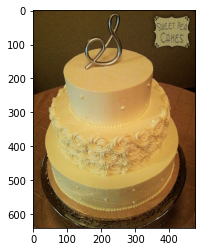

In [ ]:
generate_caption('000000122117.jpg')

---------------------Actual---------------------
A very large clock tower on the side of a church.
An old building with a clock at the top of it.
The tall clock tower is built into the corner edge of the building.
An old building has a clock tower with a weather vane.
An old building's clock tower is being displayed.
--------------------Predicted--------------------
<start> ben clock tower with a clock on it and a clock tower in the background of a building with a clock tower in the background


'<start> ben clock tower with a clock on it and a clock tower in the background of a building with a clock tower in the background'

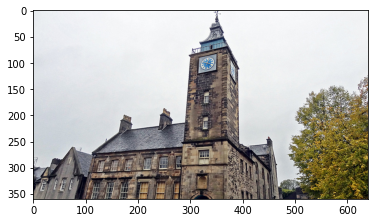

In [ ]:
generate_caption('000000000801.jpg')

---------------------Actual---------------------
A cat sitting in a bowl on a table.
A cat is sitting inside of a dish.
A cat with a purple and red collar sitting in a bowl 
a brown and white Siamese cat is sitting on a table
A siamese cat sitting on top of a table.
--------------------Predicted--------------------
<start> cat laying on a white bed with a white cat sitting on top of a table with a laptop on it and a keyboard on


'<start> cat laying on a white bed with a white cat sitting on top of a table with a laptop on it and a keyboard on'

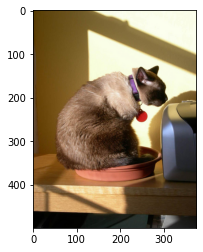

In [ ]:
generate_caption('000000004537.jpg')

---------------------Actual---------------------
A photo of two people skiing on the snow.
A man skiing on snow besides a child.
A picture of a couple people skiing in the snow.
Two people in the distance skiing against the horizon.
Two skiers in the distance under a cloudy sky.
--------------------Predicted--------------------
<start> people are flying kites on a beach near the ocean with a man on the beach and a kite in the background and a man


'<start> people are flying kites on a beach near the ocean with a man on the beach and a kite in the background and a man'

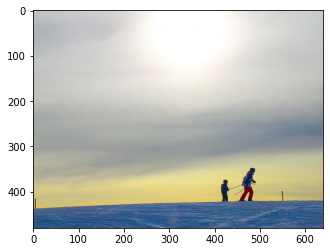

In [ ]:
generate_caption('000000543422.jpg')